In [ ]:
from IPython import display
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import time
import tensorflow_probability as tfp
from tqdm import tqdm
import matplotlib
from google.colab import files

In [ ]:
(x_train, _),(x_test, _)=tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
latent_dim=2 #dimension du vecteur latent changeable
image_size=x_train.shape[1] #image de 28 par 28 donc 28.
original_dim=image_size*image_size #va nous donner la taille de la première et dernière couche
x_train=np.reshape(x_train, [-1, original_dim]) #on redimensionne les images pour les faire rentrer dans le dense
x_test=np.reshape(x_test, [-1, original_dim]) #pareil
x_train=x_train.astype('float64')/255 #on normalise
x_test=x_test.astype('float64')/255
batch_size=32
epochs=15
input_shape=(original_dim, )
train_dataset=(tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(batch_size))
test_dataset=(tf.data.Dataset.from_tensor_slices(x_test).shuffle(len(x_test)).batch(batch_size))

In [ ]:
train_dataset

<BatchDataset shapes: (None, 784), types: tf.float64>

In [ ]:
class encodeur(tf.keras.Model):
  def __init__(self, latent_dim, original_dim):
    super(encodeur, self).__init__()
    self.latent_dim=latent_dim
    self.original_dim=original_dim
    self.dense1=tf.keras.layers.Dense(512, activation='relu')
    self.dense2=tf.keras.layers.Dense(256, activation='relu')
    self.dense3=tf.keras.layers.Dense(128, activation='relu')
    self.mean = tf.keras.layers.Dense(latent_dim)
    self.logvar = tf.keras.layers.Dense(latent_dim)
  
  def call(self, x):
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    return self.mean(x), self.logvar(x)

class decodeur(tf.keras.Model):
  def __init__(self, latent_dim, original_dim):
    super(decodeur, self).__init__()
    self.latent_dim=latent_dim
    self.original_dim=original_dim
    self.dense4=tf.keras.layers.Dense(128, activation='relu')
    self.dense5=tf.keras.layers.Dense(256, activation='relu')
    self.dense6=tf.keras.layers.Dense(512, activation='relu')
    self.sortie=tf.keras.layers.Dense(original_dim, activation='sigmoid')
  
  def call(self, x):
    x=self.dense4(x)
    x=self.dense5(x)
    x=self.dense6(x)
    return self.sortie(x)

class VAE(tf.keras.Model):
  def __init__(self, encodeur, decodeur):
    super(VAE, self).__init__()
    self.encodeur=encodeur
    self.decodeur=decodeur
  
  def parametre(self, mean, logvar):
    batch=tf.keras.backend.shape(mean)[0]
    dim=tf.keras.backend.int_shape(mean)[1]
    epsilon=tf.random.normal(shape=(batch, dim))
    return mean+tf.exp(0.5*logvar)*epsilon

  def call(self, x):
    mean, logvar=self.encodeur(x)
    x=self.parametre(mean, logvar)
    x=self.decodeur(x)
    return x, mean, logvar
    

In [ ]:
def loss(entree, sortie, mean, logvar):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(entree, sortie))
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + logvar - tf.square(mean) - tf.exp(logvar)
        kl_loss = tf.reduce_mean(kl_loss)*(-0.5)
        return reconstruction_loss + kl_loss

In [ ]:
opt=tf.keras.optimizers.Adam(1e-4)

In [ ]:
enc = encodeur(latent_dim, original_dim)
deco = decodeur(latent_dim, original_dim)
VAEE=VAE(enc, deco)

In [ ]:
time_l=[]
loss_liste=[]
start_time=time.clock()
for i in range(epochs):
  total_loss=0
  for j in train_dataset:
    with tf.GradientTape() as tape: #il calcule les gradients
      x, mean, logvar=VAEE(j)
      total_loss=loss(j, x, mean, logvar)
    grads=tape.gradient(total_loss, VAEE.trainable_weights) #calcul
    opt.apply_gradients(zip(grads, VAEE.trainable_weights))
    t=time.clock()
    time_l.append(t-start_time)
    loss_liste.append(total_loss)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

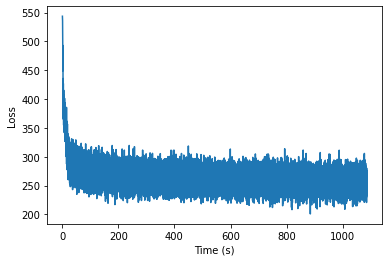

In [ ]:
#plot de la loss en fonction du temps
plt.plot(time_l, loss_liste)
plt.xlabel('Time (s)')
plt.ylabel('Loss')
plt.savefig('loss_fct_time.eps', dpi=200)
files.download("loss_fct_time.eps") 
plt.show()

In [ ]:
a,b,c=VAEE.predict(x_test)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

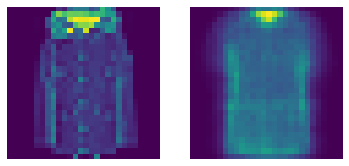

In [ ]:
fig, axs = plt.subplots(1,2)
num = random.randint(0,100)
t = x_train[num].reshape(1,-1)

out, mu, logdir = VAEE(t)
out=np.array(out).reshape(28,28)
z = np.random.randn(1, 2)

alea = np.array(deco(z)).reshape(28, 28)
axs[0].axis('off')
axs[0].imshow(t.reshape(28,28)) #Affiche le chiffre num de test_loader
axs[1].axis('off')
axs[1].imshow(out.reshape(28,28)) #Reconstruction du chiffre par l'auto-encodeur
plt.savefig('exemple_mnist.eps')
files.download("exemple_mnist.eps") 
#axs[2].axis('off')
#axs[2].imshow(alea) #Reconstruction de bruit par l'auto-encodeur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

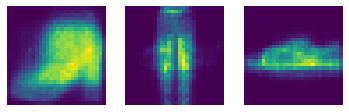

In [ ]:
fig, axs = plt.subplots(1,3)
reconst_images=deco.predict(np.random.normal(0,1,size=(3,2)))
img1=reconst_images[0]
img1=np.array(img1).reshape(28,28)
img2=reconst_images[1]
img2=np.array(img2).reshape(28,28)
img3=reconst_images[2]
img3=np.array(img3).reshape(28,28)
axs[0].axis('off')
axs[0].imshow(img1)
axs[1].axis('off')
axs[1].imshow(img2)
axs[2].axis('off')
axs[2].imshow(img3)
plt.savefig('exemple_mnist.eps')
files.download("exemple_mnist.eps")

In [ ]:
print(tf.__version__)

2.2.0
